<a href="https://colab.research.google.com/github/borisdayma/dalle-mini/blob/feat-tqdm/dev/inference/inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use [the demo](https://huggingface.co/spaces/flax-community/dalle-mini) (temporarily in beta on Huging Face Spaces but soon to be open to all).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## Install dependencies

In [ ]:
!pip install -q transformers flax
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git  # VQGAN model in JAX
!git clone https://github.com/borisdayma/dalle-mini  # Model files
%cd dalle-mini/

In [2]:
from dalle_mini.model import CustomFlaxBartForConditionalGeneration
from transformers import BartTokenizer
import jax
import random
from tqdm.notebook import tqdm, trange

In [3]:
# make sure we use compatible versions
DALLE_REPO = 'flax-community/dalle-mini'
DALLE_COMMIT_ID = '4d34126d0df8bc4a692ae933e3b902a1fa8b6114'

In [ ]:
# set up tokenizer and model
tokenizer = BartTokenizer.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)
model = CustomFlaxBartForConditionalGeneration.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)

In [5]:
# set a prompt
prompt = 'picture of a waterfall under the sunset'

In [6]:
# tokenize the prompt
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128)
tokenized_prompt

{'input_ids': DeviceArray([[    0, 37587,     9,    10, 35076,   223,     5, 18820,
                  2,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
      

Notes:

* `0`: BOS, special token representing the beginning of a sequence
* `2`: EOS, special token representing the end of a sequence
* `1`: special token representing the padding of a sequence when requesting a specific length

In [7]:
n_predictions = 8

# create random keys
seed = random.randint(0, 2**32-1)
key = jax.random.PRNGKey(seed)
subkeys = jax.random.split(key, num=n_predictions)
subkeys

DeviceArray([[3390012635, 2926294843],
             [2217417731, 1742555316],
             [1460678961, 1166258652],
             [3222599252,  530926590],
             [ 286628965,  724263916],
             [ 917745424,  814075976],
             [2369590555, 1846848485],
             [1655256846, 3835028898]], dtype=uint32)

In [8]:
# generate sample predictions
encoded_images = [model.generate(**tokenized_prompt, do_sample=True, num_beams=1, prng_key=subkey) for subkey in tqdm(subkeys)]
encoded_images[0]

FlaxSampleOutput([('sequences',
                   DeviceArray([[16384,  2778,  4815,  8447,  9355, 16314,  8493,  2635,
                                 12062, 10019, 11718, 12618, 12618, 14247, 14164, 10019,
                                  8447,  1952, 15431,  2127,  4815,  9470, 13500, 11456,
                                 12659, 15729,  6783,  1586, 11456,  4945, 16226, 12625,
                                  8447, 15917,  2325,  6060,  9819,  4238,  1464, 10805,
                                  9136, 10895,   112,   125,  1933, 10797,  9753,  4652,
                                  3132,  6060,  4319, 11228,  1400,  7634,  1400, 15276,
                                  6464,  6882,  1400,   128,  9453, 11712, 13543,  5511,
                                  7372,   381,  9819,  5401, 10200,  6882,   125,  4816,
                                  3569, 13293, 15798,  2334,  2953,  9390,  4159, 12927,
                                  5495,  4904,  5839,  1989, 14878, 12183, 137

The first token (`16384`) is a special token representing the start of a sequence in the decoder (not part of the image codebook).

In [9]:
# remove first token (BOS)
encoded_images = [img.sequences[..., 1:] for img in encoded_images]
encoded_images[0]

DeviceArray([[ 2778,  4815,  8447,  9355, 16314,  8493,  2635, 12062,
              10019, 11718, 12618, 12618, 14247, 14164, 10019,  8447,
               1952, 15431,  2127,  4815,  9470, 13500, 11456, 12659,
              15729,  6783,  1586, 11456,  4945, 16226, 12625,  8447,
              15917,  2325,  6060,  9819,  4238,  1464, 10805,  9136,
              10895,   112,   125,  1933, 10797,  9753,  4652,  3132,
               6060,  4319, 11228,  1400,  7634,  1400, 15276,  6464,
               6882,  1400,   128,  9453, 11712, 13543,  5511,  7372,
                381,  9819,  5401, 10200,  6882,   125,  4816,  3569,
              13293, 15798,  2334,  2953,  9390,  4159, 12927,  5495,
               4904,  5839,  1989, 14878, 12183, 13769,  9713,  3168,
               5401, 12618, 10019, 15771,  6172,  8361,  7315, 11196,
               7372, 14717,  4465,  2255,  2129,  5509,  9035,  1570,
              15883,  3132,  6920, 11904,  9899,  2428,  8413,   271,
              10225,

The generated images are now represented by 256 tokens.

In [10]:
encoded_images[0].shape

(1, 256)

## Decode images

The generated images need to be decoded with `flax-community/vqgan_f16_16384`.

In [11]:
from vqgan_jax.modeling_flax_vqgan import VQModel
import numpy as np
from PIL import Image

In [12]:
# make sure we use compatible versions
VQGAN_REPO = 'flax-community/vqgan_f16_16384'
VQGAN_COMMIT_ID = '90cc46addd2dd8f5be21586a9a23e1b95aa506a9'

In [13]:
# set up VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [14]:
# decode images
decoded_images = [vqgan.decode_code(encoded_image) for encoded_image in tqdm(encoded_images)]
decoded_images[0]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.



DeviceArray([[[[0.42008442, 0.40290695, 0.20148636],
               [0.41641164, 0.42523348, 0.18507643],
               [0.4247604 , 0.41247207, 0.21909784],
               ...,
               [0.23339447, 0.21682811, 0.11815949],
               [0.22238952, 0.20761107, 0.10414089],
               [0.23872986, 0.23835506, 0.13786517]],

              [[0.4141901 , 0.40987   , 0.18329902],
               [0.43430394, 0.41234633, 0.18813388],
               [0.43903285, 0.41125858, 0.24226941],
               ...,
               [0.24042144, 0.22371142, 0.12781653],
               [0.23016843, 0.22601368, 0.11111371],
               [0.23474264, 0.2220283 , 0.1309533 ]],

              [[0.41387978, 0.4131611 , 0.22063692],
               [0.43575597, 0.42432278, 0.21298702],
               [0.42155382, 0.40814832, 0.23043938],
               ...,
               [0.23480469, 0.22098835, 0.12696254],
               [0.24546853, 0.23742102, 0.11789374],
               [0.23826054, 0.23121

In [15]:
# normalize images
clipped_images = [img.squeeze().clip(0., 1.) for img in decoded_images]

In [16]:
# convert to image
images = [Image.fromarray(np.asarray(img * 255, dtype=np.uint8)) for img in clipped_images]

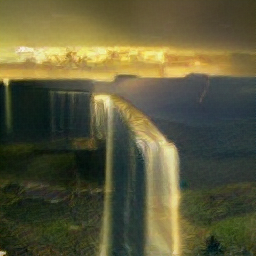

In [17]:
# display an image
images[0]

## Rank images with CLIP

We use `openai/clip-vit-base-patch32` to rank generated images against the prompt.

In [18]:
from transformers import CLIPProcessor, FlaxCLIPModel

# modules required for normalizing images
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

In [19]:
# set up model and processor
clip = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [20]:
# image pre-processing used by CLIP
def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        lambda image: image.convert("RGB"),
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

transforms = _transform(224)

In [21]:
# normalize images as expected by CLIP
normalized_images = [transforms(image) for image in images]

In [22]:
# evaluate scores
inputs = processor(text=prompt, images=normalized_images, return_tensors='np')
logits = clip(**inputs).logits_per_image
scores = jax.nn.softmax(logits, axis=0).squeeze()  # normalize and sum all scores to 1

Prompt: picture of a waterfall under the sunset

Score: 0.6374813318252563


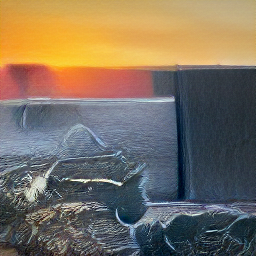


Score: 0.12770606577396393


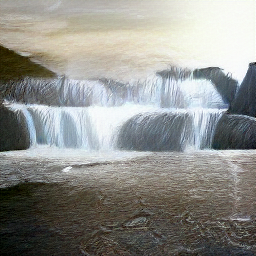


Score: 0.09121641516685486


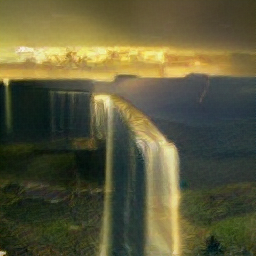


Score: 0.07441458851099014


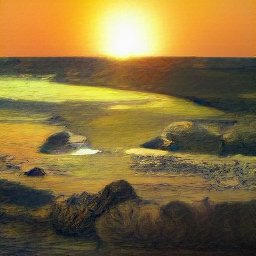


Score: 0.06225498765707016


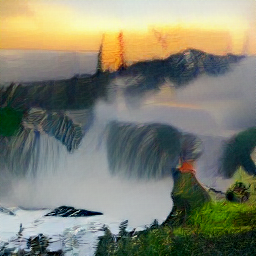


Score: 0.0029347259551286697


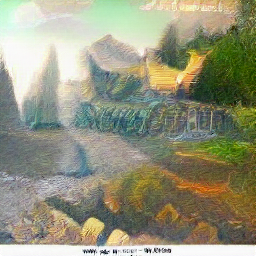


Score: 0.0022958300542086363


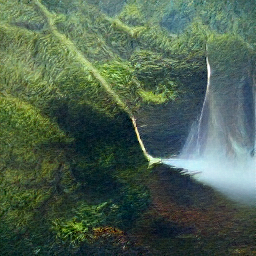


Score: 0.001696077291853726


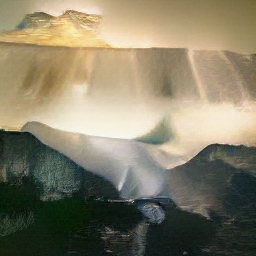

In [23]:
# rank images by score
print(f'Prompt: {prompt}\n')
for idx in scores.argsort()[::-1]:
    print(f'Score: {scores[idx]}')
    display(images[idx])
    print()

## Leverage JAX for faster inference

[JAX](https://github.com/google/jax) uses XLA to compile code to GPU/TPU, leading to faster inference.

Even with only 1 GPU, we can benefit from impressive speedups, even more after first inference (where the compilation happens).

In [24]:
from functools import partial
from flax.training.common_utils import shard
from flax.jax_utils import replicate

In [25]:
# check we can access TPU's or GPU's
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [26]:
# replicate parameters on all devices
dalle_params = replicate(model.params)
vqgan_params = replicate(vqgan.params)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [27]:
# one set of inputs per device
prompt = ['picture of a waterfall under the sunset'] * jax.device_count()

In [28]:
# tokenize prompts and shard them across available devices
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128).data
tokenized_prompt = shard(tokenized_prompt)

We use `pmap` to compile the functions with XLA and perform operations in parallel on multiple devices.

In [29]:
# parallelize and compile functions

# function to generate encoded images
@partial(jax.pmap, axis_name="batch")
def p_generate(tokenized_prompt, key, params):
    return model.generate(
        **tokenized_prompt,
        do_sample=True,
        num_beams=1,
        prng_key=key,
        params=params
    )

# function to decode images
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

In [32]:
# generate images with compiled functions
n_predictions = 8
images = []

for i in trange(n_predictions // jax.device_count()):
    key, *subkeys = jax.random.split(key, jax.device_count() + 1)
    subkeys = jax.numpy.stack(subkeys)

    encoded_images = p_generate(tokenized_prompt, subkeys, dalle_params)
    encoded_images = encoded_images.sequences[..., 1:]

    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0., 1.).reshape((-1, 256, 256, 3))

    for img in decoded_images:
        images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

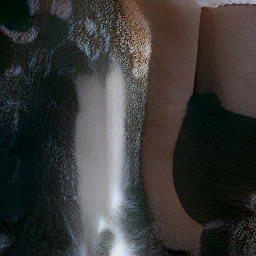

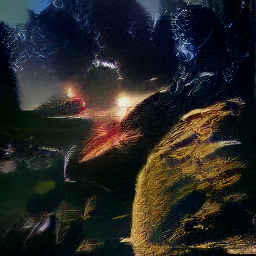

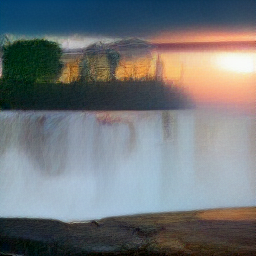

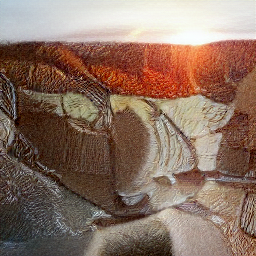

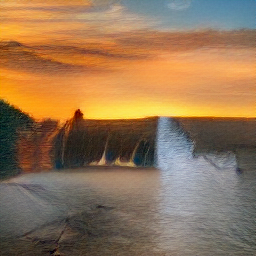

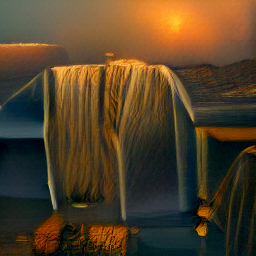

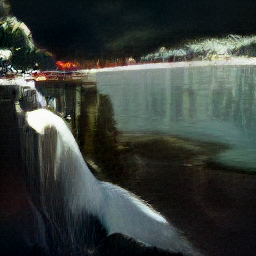

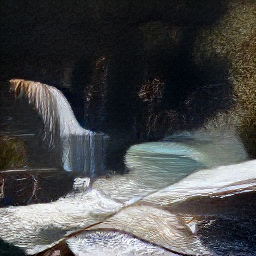

In [33]:
for img in images:
    display(img)
    print()